# Decode pipeline for FSK signals

This notebook walks you through the code in [fsk_decode.py](pyrtlfm/fsk_decode.py), which decodes Frequency Shift Keyed radio frames via these steps:
1. Consume a frame from RTL-STDR.
2. Find a region of high amplitude in it.
3. Compute the phase velocity time series encoded in that high amplitude region.
4. Determine the time offset, width, and threshold for a bit from the preamble in that region.
5. Decode bits using the above information.
6. Search for a binary marker that indicates the start of the packet.

In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib widget

import decode
import packets
import capture
import fsk_decode

/Users/ali/pyrtlfm/.venv/lib/python3.10/site-packages/rtlsdr/__init__.py:19: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  import pkg_resources


# Capture packets

First, capture packets from the radio, and dump them to disk. This looks for SDR frames that have energy above a squelch threshold, and saves those frames to disk.

In [ ]:
frames = capture.capture_packets()
packets.save_packets(frames, "data/capture.pkl")

#  Load a previous capture

Maybe you don't want to capture a new dataset just now and want to load an old one instead. Run this instead:

In [2]:
frames = packets.load_packets("data/capture.pkl")

# Examine a given packet

Let's examine the high energy regions of the very frame frame:

  freq deviation from baseband: -5.0 kHz, bit_width: 32.1 samples, range duration: 9395 samples (31.32 ms)
  preamble -> data: ...(59 bits) 01010101 | 10100100 (233 bits)...


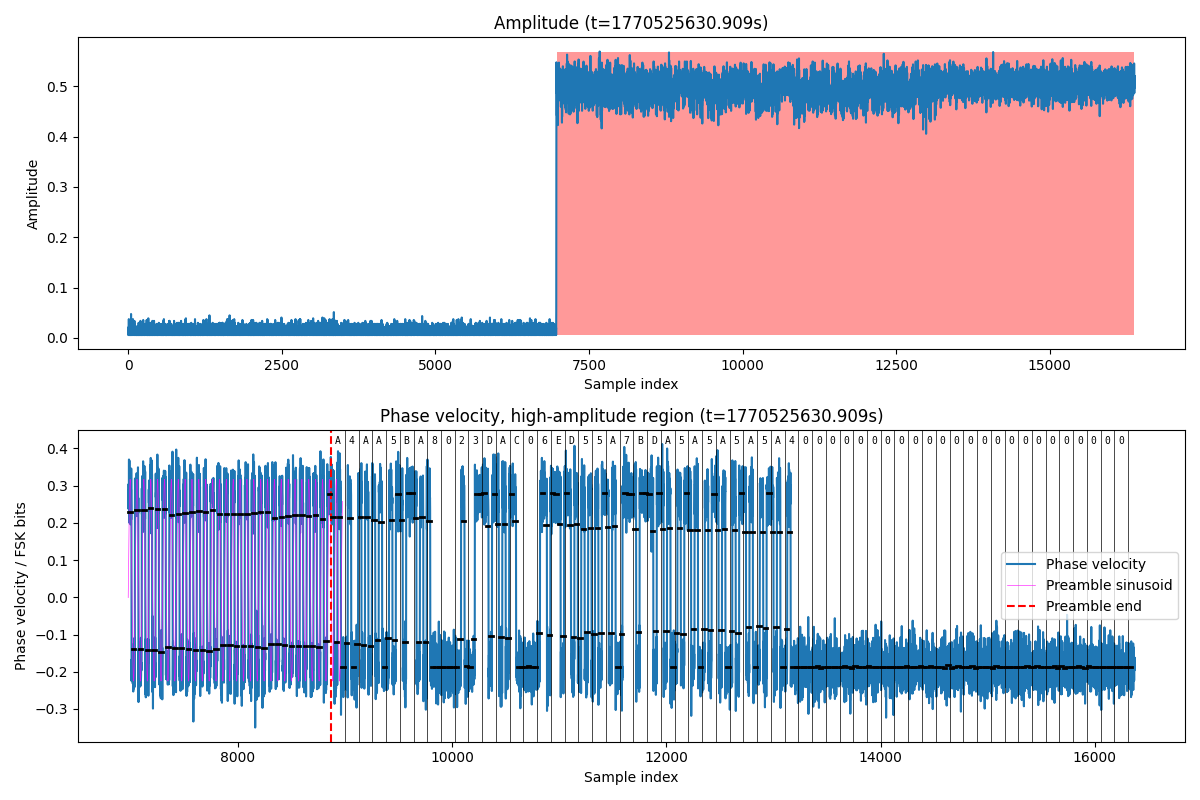

In [3]:
for srange in fsk_decode.find_run_of_high_amplitude(frames[0]):
    fsk_decode.decode_frame(frames[0], srange)

Some things to notice in the above:
* The region of high energy is highlighted in red in the top panel. It constitutes about half the frame.
* The second panel shows the phase velocity (see section below for an explanation of what this is). The value of a bit can be read almost directly from this signal.
* There is an initial region where the value of a bit rapidly flips. This is the preamble. We've fit a sinusoid to it to recover the phase, amplitude, vertical offset, and width of a bit (see section below for how this works)
* The value of a bit is determined by thresholding the average value of the phase velocity during the span of a bit.
* After this preamble, each group of 4 bits is decoded into a nibble whose value is rendered at the top of the second axis.

# Decode all the packets

Let's print the binary representation of all the packets we've extracted. Some of these
have a tell-tale string 0x552dd4. These are from a wireless thermometer that's in a nearby hot tub.  Convert its output to ºC:

In [4]:
for ipacket, frame in enumerate(frames):
    for srange in fsk_decode.find_run_of_high_amplitude(frame):
        data_bits = fsk_decode.decode_frame(frame, srange, show_plot=False)
        
        print("\n=====", ipacket,  frame.timestamp - frames[0].timestamp, "sec")
        
        data_bits_thermopro = decode.find_after(data_bits, 0x552dd4)

        if len(data_bits_thermopro):
            data_uint8 = decode.bits_to_uint8(data_bits_thermopro)
            bytes_34 = ((data_uint8[3] & 0x0f) * 256.) + data_uint8[4]
            temp_C = 0.1 * (bytes_34-500)
            temp_F = temp_C * 9/5 + 32
            print(f"Temperature: {temp_C:.1f} C, {temp_F:.1f} F")
        else:
            data_uint8 = decode.bits_to_uint8(data_bits)
            print(decode.uint8_to_hex(data_uint8))



===== 0 0.0 sec
Temperature: 38.6 C, 101.5 F

===== 5 50.026341915130615 sec
Temperature: 38.6 C, 101.5 F

===== 7 99.99779891967773 sec
Temperature: 38.6 C, 101.5 F

===== 13 150.02383303642273 sec
Temperature: 38.6 C, 101.5 F

===== 15 199.9950749874115 sec
Temperature: 38.6 C, 101.5 F

===== 17 250.02058601379395 sec
Temperature: 38.6 C, 101.5 F

===== 21 299.9929280281067 sec
Temperature: 38.6 C, 101.5 F


/Users/ali/pyrtlfm/.venv/lib/python3.10/site-packages/numpy/_core/fromnumeric.py:3860: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/ali/pyrtlfm/.venv/lib/python3.10/site-packages/numpy/_core/_methods.py:145: RuntimeWarning: invalid value encountered in divide
  ret = ret.dtype.type(ret / rcount)


# Details about decoding

Let's dive into how the above works.

## The signal

The transmitter encodes a binary signal $s(t) \in {0,1}$ using FSK, at a baseband of $\omega_0$, with low bits oscillating
at $\omega_0 - \Delta_\omega$ and high bits at $\omega_0 + \Delta_\omega$. Formally, the electric field the emitter generates is

$$f(t) = \exp\left(j\omega_0 t + j \Delta_\omega s(t) \cdot t \right).$$

The decoder multiplies this by the signal $\exp(-j \omega_0 t)$, bandpasses the resulting signal, and digitizes it. The frames
we receive from the SDR are therefore digitized versions of

$$\hat{f}(t) = \exp\left(j \Delta_\omega s(t) \cdot t \right).$$

The first step of the pipeline above is to compute the phase velocity. The phase velocity is
$$
\frac{\partial}{\partial t}\angle \hat{f}(t) = \frac{\partial}{\partial t}\Delta_\omega s(t) t = \Delta_\omega s(t).
$$

We don't actually use this formula. Since our best hope is to approximate derivatives with finish differences, we'll
approximate
$$\begin{align}
\frac{\partial}{\partial t}\angle \hat{f}(t) &\approx \frac{1}{\delta t} \hat{f}(t+\delta t) \cdot \hat{f}^*(t) \equiv v(t)\\
&= \frac{1}{\delta t} \Delta_\omega s(t) \delta t \\
&=  \Delta_\omega s(t).
\end{align}$$

## Decoding $s(t)$ from $v(t)$ by fitting a sinusoid

Of all the parameters above, we only have the baseband frequency $\omega_0$ (915
Mhz for the signal we're capturing). $\Delta_\omega$ is unavailable to us. The
width of a bit in $s(t)$ is also unknown. We also don't know the start of a bit
with respect to the start of a frame.  To help us recover these things, $s(t)$
always starts with an alternating sequence of bits ...010101... This pattern is
enough to recover all the parameters of interest. We'll recover these parameters
by fitting a sinusoid to the early parts of $v(t)$.

Below is the sinusoid fitting algorithm in action on synthetically generated, randomly corrupted sinusoid:

<IPython.core.display.Javascript object>

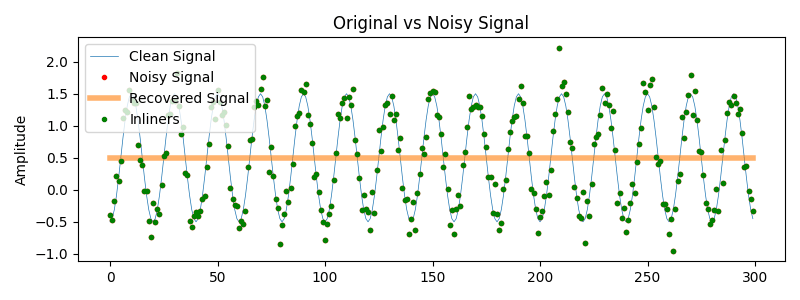

         parameter  true    fitted  pct_diff
0        frequency  0.05  0.049955  0.090707
1            phase  5.00  4.906564  1.868722
2        amplitude  1.00  0.995595  0.440546
3  vertical_offset  0.50  0.484312  3.137531


In [8]:
import demo_fit_sinusoid
demo_fit_sinusoid.demo_fit_random_signal()

![](data/demo_fit_random_signal.gif)

The fitting algorithm tries to consume as much of the preamble as possible to
get a good lock on the signal. It takes as input the phase velocity, and a guess
about the lenth of the preamble. To make sure it's privy to the most data
available, I give it an upper bound on the length of the preamble.  The fitting
algorithms operates in annealing phases. Initially, it looks only at the early
parts of the signal, and ignores the rest. It gradually brings into
consideration later samples, ignoring the ones that deviate significantly from
the pattern observed so far, and refines its estimate. The animation below shows
in green dots the samples the algorithm consider as it advances through the
annealing stages.

Here it is in action on a real phase velocity signal I picked up on the antenna:

<IPython.core.display.Javascript object>

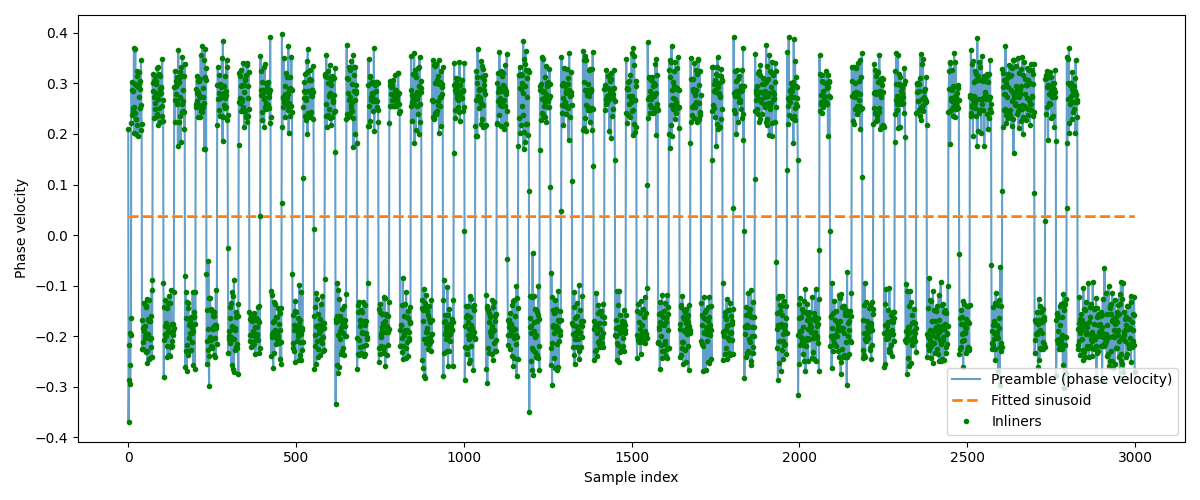

In [7]:
demo_fit_sinusoid.demo_fit_radio(frames[0], num_sample_in_preamble=3000)

![](data/demo_fit_radio.gif)

Here are the parameters of the sinusoid. From here, we can recover the width of the bits, and the threshold for determining 0 vs 1:

In [9]:
import fit_sinusoid
fit_sinusoid.SinusoidParams._fields

('frequency', 'phase', 'amplitude', 'vertical_offset')